# Cats and Dogs from [CIFAR10](https://keras.io/datasets/)!

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%tensorflow_version 2.x

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

# getting the datset
from keras.datasets import cifar10
from keras import backend as K

** Load Cats and Dogs From CIFAR10 dataset **

First we load the CIFAR10 data and extract all cats and dogs from it.

170498071/170498071 [==============================] - 102s 1us/step
x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
channels_last


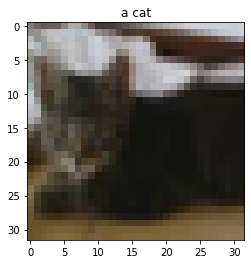

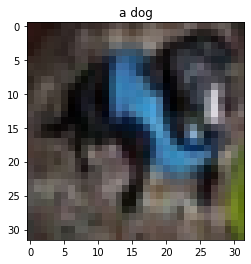

In [2]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Reduce to cats and dogs
def extract(x,y,labels):
    arg_train = []
    new_y = np.zeros(np.max(labels)+1)
    for i,l in enumerate(labels):
        arg_train.append(np.argwhere(y == l)[:,0])
        new_y[l] = i
    arg_train = np.concatenate(arg_train)
    return x[arg_train], new_y[y[arg_train]]
    
x_train, y_train = extract(x_train, y_train, [3,5])
x_test, y_test = extract(x_test, y_test, [3,5])

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

img_rows, img_cols, channels = x_train.shape[1:]

print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

plt.imshow(x_train[np.argmax(y_train==0)])
plt.title("a cat")
plt.show()
plt.imshow(x_train[np.argmax(y_train==1)])
plt.title("a dog")
plt.show()

Next, we just define a function which will display the results later.

In [3]:
def predict(idx, model, data, avg=None, norm=None, cols=5, threshold=.3):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    cats = 0
    dogs = 0
    data = data[idx]
    if norm is None:
        p = model.predict(data)
    else:
        p = model.predict(data/norm)
    i = 0
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax in axs:
            if avg is not None:
                img = (data[i]+avg)
            else:
                img = (data[i])

            ax.imshow(img)
            if p[i] < threshold:
                label = "cat"
                cats += 1
            elif p[i] > 1-threshold:
                label = "dog"
                dogs += 1
            else:
                label = "not sure"
            ax.text(.5,0, label+ "; score = " + str(p[i]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
        plt.show()
    print(cats, " cats (", cats/len(idx)*100., "%),", dogs, " dogs (", dogs/len(idx)*100., "%)")

In [4]:
batch_size = 128

# Convolutional Neural Network

A very simple CNN... (> 70% validation accuray after 10 epochs)

In [7]:

model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=0.001) #keras.optimizers.Adadelta()

model1.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3211520   
                                                      

c:\Users\rando\anaconda3\envs\naparienv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We will train for ten epochs (iterations ofer the whole training data)...

In [8]:
model1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
79/79 [==============================] - 19s 93ms/step - loss: 0.6734 - accuracy: 0.5729 - val_loss: 0.6320 - val_accuracy: 0.6405
Epoch 2/10
79/79 [==============================] - 1s 13ms/step - loss: 0.6013 - accuracy: 0.6760 - val_loss: 0.5727 - val_accuracy: 0.7085
Epoch 3/10
79/79 [==============================] - 1s 13ms/step - loss: 0.5485 - accuracy: 0.7242 - val_loss: 0.5339 - val_accuracy: 0.7260
Epoch 4/10
79/79 [==============================] - 1s 13ms/step - loss: 0.5219 - accuracy: 0.7422 - val_loss: 0.5319 - val_accuracy: 0.7365
Epoch 5/10
79/79 [==============================] - 1s 12ms/step - loss: 0.4778 - accuracy: 0.7690 - val_loss: 0.5379 - val_accuracy: 0.7250
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.4450 - accuracy: 0.7899 - val_loss: 0.5209 - val_accuracy: 0.7470
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.3980 - accuracy: 0.8168 - val_loss: 0.5235 - val_accuracy: 0.7500
Epoch 8/10
7

1/1 [==============================] - 0s 287ms/step


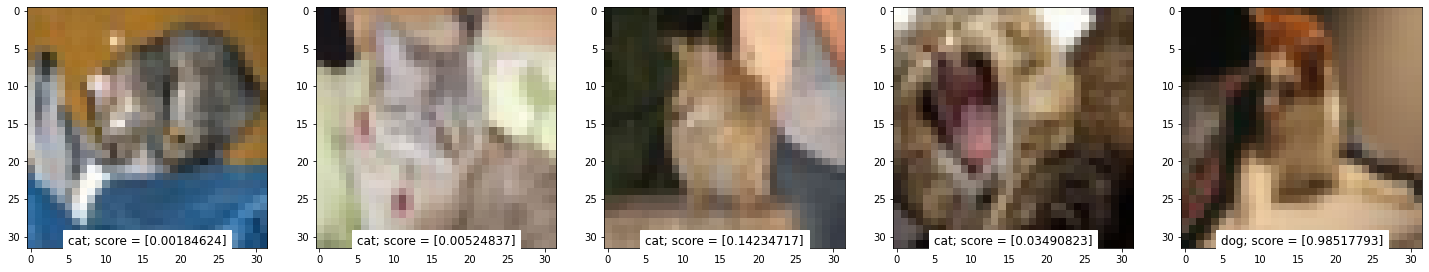

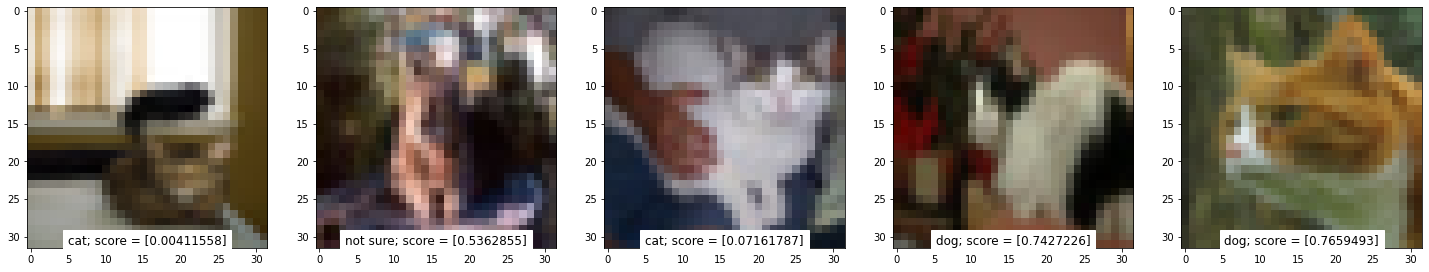

6  cats ( 60.0 %), 3  dogs ( 30.0 %)
1/1 [==============================] - 0s 20ms/step


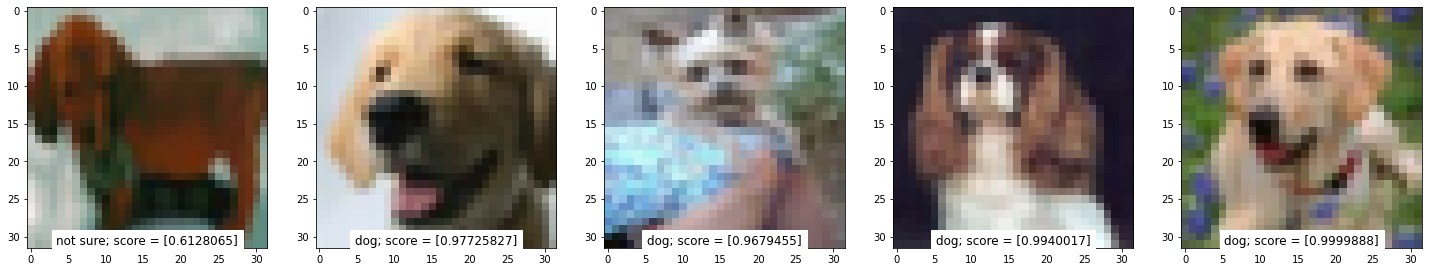

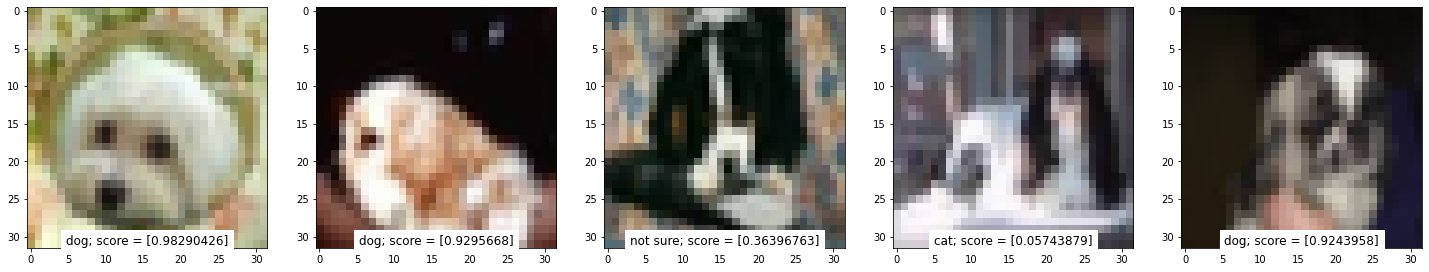

1  cats ( 10.0 %), 7  dogs ( 70.0 %)


In [9]:
predict(range(10), model1, x_test)
predict(range(x_test.shape[0]-10, x_test.shape[0]), model1, x_test)

A rather simple CNN: Deeper that the one above, but actually with fewer trainable parameters. It gives slightly better performance

In [11]:
model2 = Sequential()
model2.add(Conv2D(48, kernel_size=(5, 5), padding="same",
                 activation='relu', input_shape=input_shape))
model2.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(96, (5, 5), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(160, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
model2.add(Flatten())
model2.add(Dropout(.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

opt = keras.optimizers.Adam(lr=0.001)

model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 48)        3648      
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        38432     
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 96)       

In [12]:
model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
79/79 [==============================] - 6s 52ms/step - loss: 0.7189 - accuracy: 0.5475 - val_loss: 0.6892 - val_accuracy: 0.5260
Epoch 2/10
79/79 [==============================] - 3s 33ms/step - loss: 0.6615 - accuracy: 0.6035 - val_loss: 0.6667 - val_accuracy: 0.6200
Epoch 3/10
79/79 [==============================] - 3s 34ms/step - loss: 0.6232 - accuracy: 0.6435 - val_loss: 0.7070 - val_accuracy: 0.5245
Epoch 4/10
79/79 [==============================] - 3s 34ms/step - loss: 0.5929 - accuracy: 0.6798 - val_loss: 0.6593 - val_accuracy: 0.6020
Epoch 5/10
79/79 [==============================] - 3s 34ms/step - loss: 0.5490 - accuracy: 0.7168 - val_loss: 0.5950 - val_accuracy: 0.6670
Epoch 6/10
79/79 [==============================] - 3s 34ms/step - loss: 0.5215 - accuracy: 0.7417 - val_loss: 0.5441 - val_accuracy: 0.7145
Epoch 7/10
79/79 [==============================] - 3s 34ms/step - loss: 0.4831 - accuracy: 0.7656 - val_loss: 0.5121 - val_accuracy: 0.7430
Epoch 8/10
79

1/1 [==============================] - 1s 562ms/step


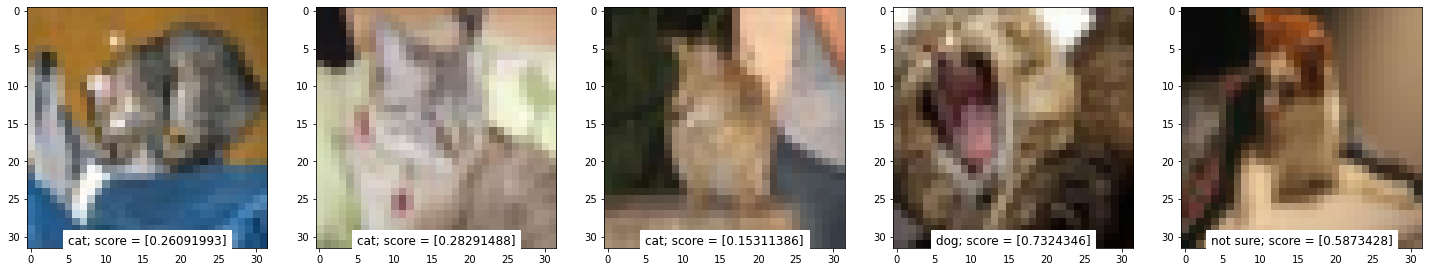

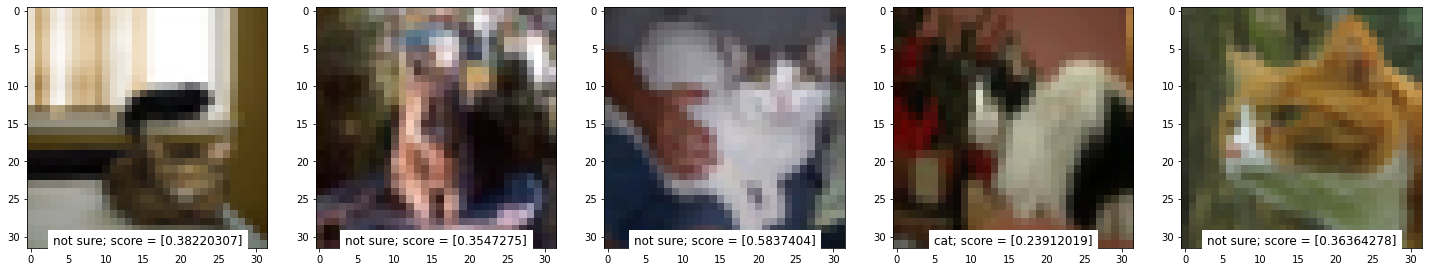

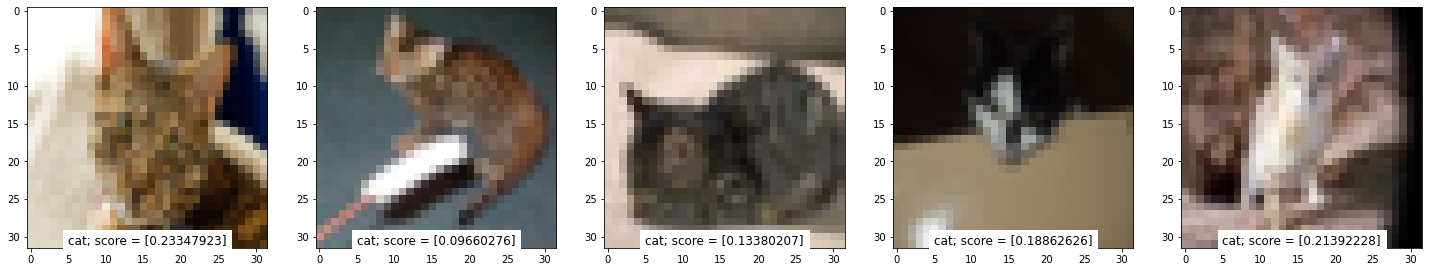

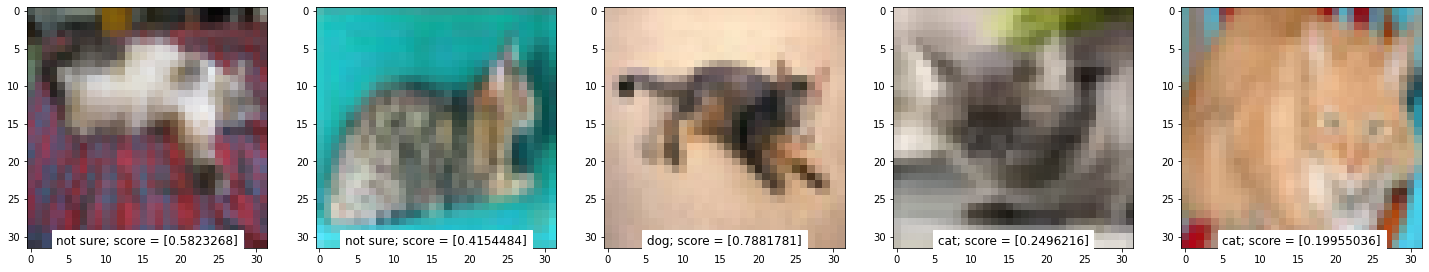

11  cats ( 55.00000000000001 %), 2  dogs ( 10.0 %)
1/1 [==============================] - 0s 14ms/step


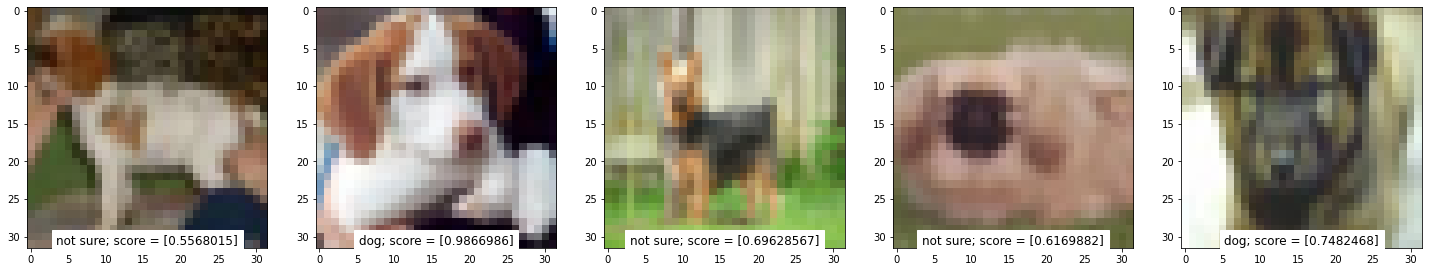

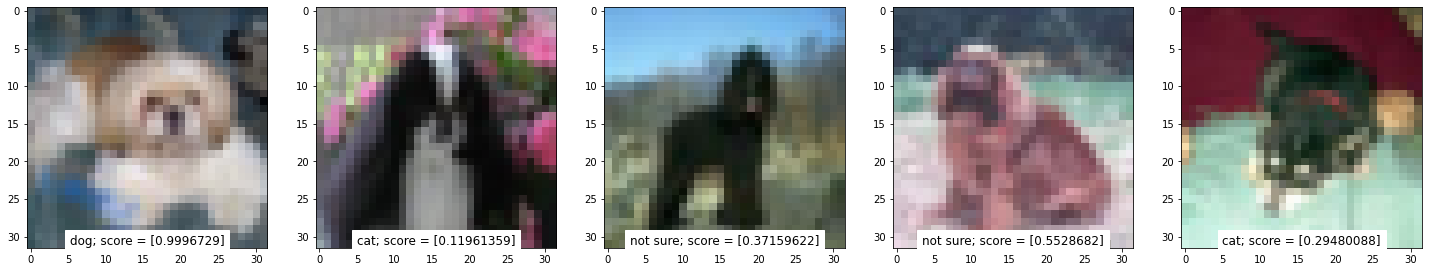

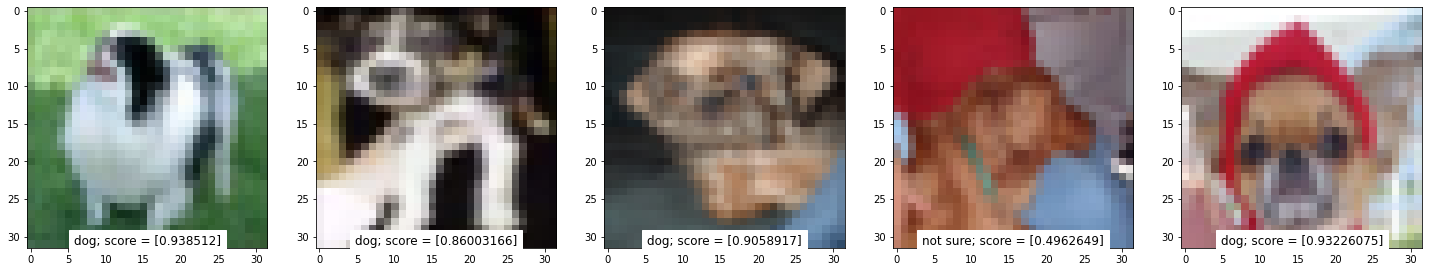

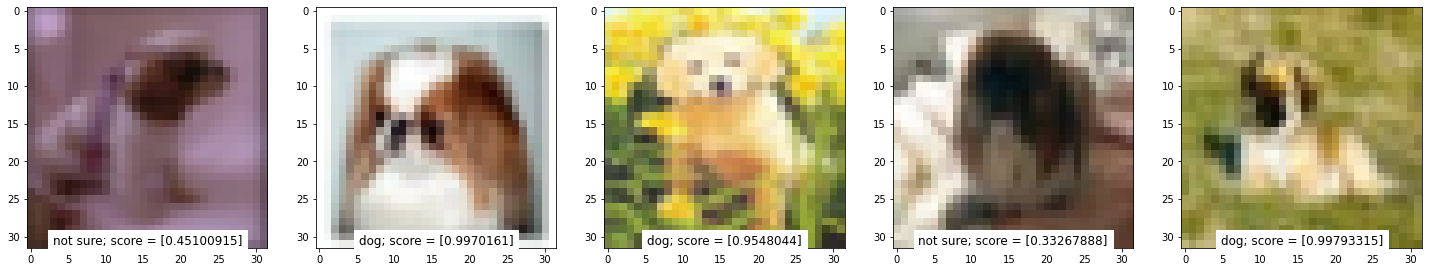

2  cats ( 10.0 %), 10  dogs ( 50.0 %)


In [13]:
predict(range(20), model2, x_test)
predict(range(x_test.shape[0]//2, x_test.shape[0]//2+20), model2, x_test)

## Data Augmentation

Looking at the training progress we can see, that in the end the loss decreases but the validation loss does not. The network is only optimized for the training data. The test data is used to validate the performance on unseen images. What we observe here is called overfitting. This problem will be adressed in depth in the session on regularization.

One simple explanation for the phenomenon in our case is, that we have limited training data over which we interate over and over and many parameters in our network which can *memorize* the data. One way to get more data is augmenting the available data with randomly transformed data which stil retains the same labels.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# traning data is augmented
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

With the augmented training data we can continue training and improve the results on the test set.

In [15]:
model2.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Epoch 1/50


C:\Users\rando\AppData\Local\Temp\ipykernel_3716\1939904693.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(


15/15 [==============================] - 2s 81ms/step - loss: 0.4683 - accuracy: 0.7777 - val_loss: 0.5116 - val_accuracy: 0.7670
Epoch 2/50
15/15 [==============================] - 1s 53ms/step - loss: 0.4588 - accuracy: 0.7766 - val_loss: 0.5490 - val_accuracy: 0.6955
Epoch 3/50
15/15 [==============================] - 1s 54ms/step - loss: 0.4307 - accuracy: 0.8021 - val_loss: 0.5655 - val_accuracy: 0.7195
Epoch 4/50
15/15 [==============================] - 1s 53ms/step - loss: 0.4377 - accuracy: 0.7969 - val_loss: 0.5168 - val_accuracy: 0.7365
Epoch 5/50
15/15 [==============================] - 1s 53ms/step - loss: 0.4187 - accuracy: 0.8016 - val_loss: 0.4790 - val_accuracy: 0.7720
Epoch 6/50
15/15 [==============================] - 1s 54ms/step - loss: 0.4264 - accuracy: 0.8057 - val_loss: 0.5235 - val_accuracy: 0.7625
Epoch 7/50
15/15 [==============================] - 1s 52ms/step - loss: 0.4156 - accuracy: 0.8073 - val_loss: 0.4369 - val_accuracy: 0.7960
Epoch 8/50
15/15 [======

In [16]:
from keras import layers, models
img_input = layers.Input(shape = (input_shape[0], input_shape[1], input_shape[2]))
x = (Conv2D(48, kernel_size=(5, 5), padding="same",
                 activation='relu', input_shape=input_shape))(img_input)
x = (Conv2D(32, (5, 5), activation='relu', padding="same"))(x)
x = (Conv2D(32, (3, 3), activation='relu', padding="same"))(x)
x = (MaxPooling2D(pool_size=(2, 2)))(x)
x = (BatchNormalization())(x)
x = (Conv2D(96, (5, 5), activation='relu', padding="same"))(x)
x = (Conv2D(64, (3, 3), activation='relu', padding="same"))(x)
x = (Conv2D(64, (3, 3), activation='relu', padding="same"))(x)
x = (MaxPooling2D(pool_size=(2, 2)))(x)
x = (BatchNormalization())(x)
x = (Conv2D(160, (3, 3), activation='relu', padding="same"))(x)
x = (Conv2D(128, (3, 3), activation='relu', padding="same"))(x)
x = (MaxPooling2D(pool_size=(2, 2)))(x)
x = (BatchNormalization())(x)
x = (Conv2D(256, (3, 3), activation='relu', padding="same"))(x)
x = (Flatten())(x)
x = (Dropout(.3))(x)
x = (Dense(512, activation='relu'))(x)
x = (Dropout(.5))(x)
x = (Dense(128, activation='relu'))(x)
x = (Dense(1))(x)
x = (Activation('sigmoid'))(x)

outputs = x
model3 = models.Model(img_input, outputs)
opt = keras.optimizers.Adam(lr=0.001)

model3.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 48)        3648      
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        38432     
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                             

In [17]:
model3.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Epoch 1/50


C:\Users\rando\AppData\Local\Temp\ipykernel_3716\1618940671.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3.fit_generator(


15/15 [==============================] - 2s 62ms/step - loss: 0.8943 - accuracy: 0.5031 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/50
15/15 [==============================] - 1s 56ms/step - loss: 0.7113 - accuracy: 0.5276 - val_loss: 0.7014 - val_accuracy: 0.4980
Epoch 3/50
15/15 [==============================] - 1s 51ms/step - loss: 0.7062 - accuracy: 0.5297 - val_loss: 0.6947 - val_accuracy: 0.4680
Epoch 4/50
15/15 [==============================] - 1s 50ms/step - loss: 0.6859 - accuracy: 0.5458 - val_loss: 0.6937 - val_accuracy: 0.5130
Epoch 5/50
15/15 [==============================] - 1s 50ms/step - loss: 0.6854 - accuracy: 0.5771 - val_loss: 0.6914 - val_accuracy: 0.5125
Epoch 6/50
15/15 [==============================] - 1s 51ms/step - loss: 0.6929 - accuracy: 0.5542 - val_loss: 0.6893 - val_accuracy: 0.5120
Epoch 7/50
15/15 [==============================] - 1s 50ms/step - loss: 0.6869 - accuracy: 0.5490 - val_loss: 0.6927 - val_accuracy: 0.5005
Epoch 8/50
15/15 [======